In [31]:
import os
import numpy as np
from astropy.io import fits
from astropy.table import Table, Column, join, hstack,vstack,unique
from astropy.cosmology import FlatLambdaCDM,z_at_value
import astropy.units as u
from scipy.stats import norm 

import logging
import healpy as hp
import matplotlib as mpl
import matplotlib.pyplot as plt
from gw_skymap import compute_quantiles, compute_contours, plot_mollmap, plot_cartmap


In [14]:
mpl.rc('font',size=12)

In [15]:
gwfile='/hildafs/projects/phy220048p/share/Dark_sirens/GW190412_skymap.fits.gz'
pb,distmu,distsigma,distnorm=hp.read_map(gwfile,field=range(4),memmap=True)
NSIDE=hp.npix2nside(len(pb))
pixarea=hp.nside2pixarea(NSIDE)
pixarea_deg=hp.nside2pixarea(NSIDE,degrees=True)
pb_frac=0.9

In [16]:
def draw_sv(ra_min,ra_max,dec_min,dec_max,color='g'):
    y = np.arange(dec_min, dec_max+0.1, 0.1)
    x = np.full_like(y, ra_min)
    hp.projplot(x, y, lonlat=True, color=color, lw=1, ms=0)
    
    x = np.full_like(y, ra_max)
    hp.projplot(x, y, lonlat=True, color=color, lw=1, ms=0)
    
    x = np.arange(ra_min, ra_max+0.1, 0.1)
    y = np.full_like(x, dec_max)
    hp.projplot(x, y, lonlat=True, color=color, lw=1, ms=0)
    
    y = np.full_like(x, dec_min)
    hp.projplot(x, y, lonlat=True, color=color, lw=1, ms=0)

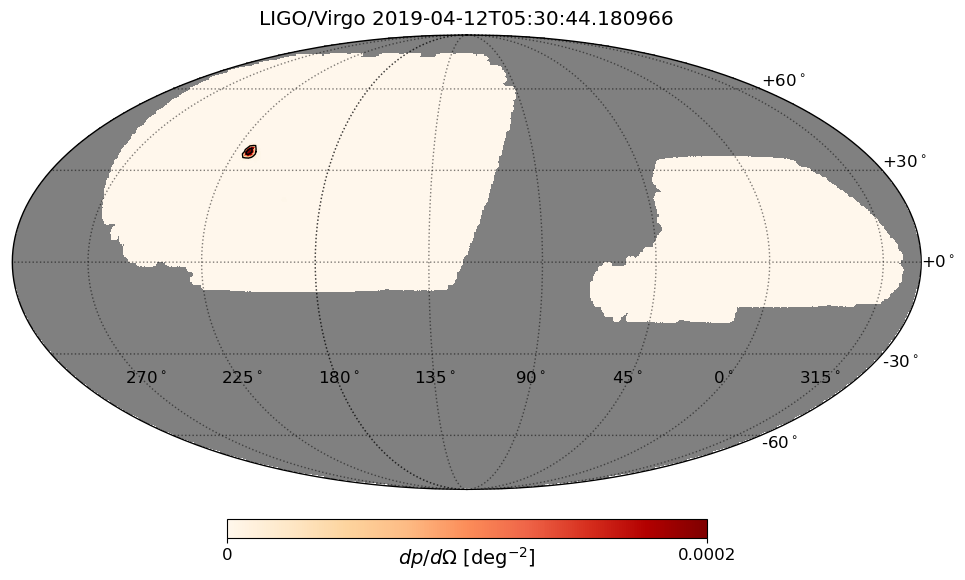

In [17]:
fig = plot_mollmap(gwfile, rot=120)
fig.savefig('GW190412_desi_footprint.png', dpi=120)

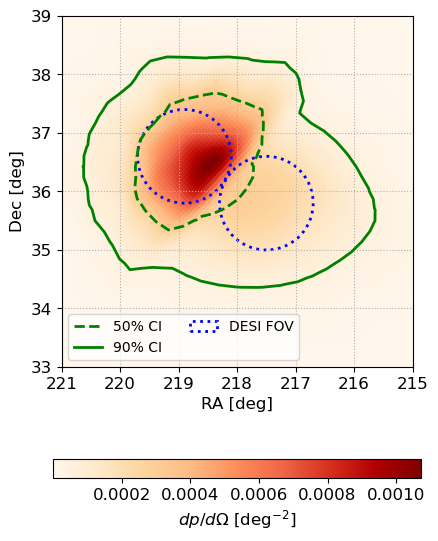

In [18]:
fig = plot_cartmap(gwfile, tile_ra=[218.9,217.5], tile_dec=[36.6,35.8], angsize=3)

In [19]:
z_min=0.001
z_max=0.5
H0_min=20
H0_max=140
Omega_m=0.3
nsigma=1.65

catalog_name="/hildafs/projects/phy220048p/wballard/scanner/ReducedCatalog.fits"
h=fits.open(catalog_name,memmap=True)[1].data
ra=h['TARGET_RA']
z=h['Z']
dec=h['TARGET_DEC']
pix=h['hpix1024']

i = np.flipud(np.argsort(pb))
sorted_credible_levels = np.cumsum(pb[i])
credible_levels = np.empty_like(sorted_credible_levels)
credible_levels[i] = sorted_credible_levels

mask_pix=(credible_levels<=pb_frac)
cred_cut=credible_levels[mask_pix]
cut_idx=i[:len(cred_cut)]
roi_area=np.sum(mask_pix) * hp.nside2pixarea(NSIDE, degrees=True)
ramax,decmax=hp.pix2ang(NSIDE,np.argmax(pb),lonlat=True)
print("Highest probability pixel is at RA,Dec = ",ramax,decmax)
distmu_avg=np.average(distmu[mask_pix],weights=pb[mask_pix])
distsig_avg=np.average(distsigma[mask_pix],weights=pb[mask_pix])

cosmomin=FlatLambdaCDM(H0=H0_min,Om0=Omega_m)
cosmomax=FlatLambdaCDM(H0=H0_max,Om0=Omega_m)
d_min=distmu_avg-(nsigma*distsig_avg)
d_max=distmu_avg+(nsigma*distsig_avg)
z_min=max(z_min,z_at_value(cosmomin.luminosity_distance,d_min*u.Mpc,zmin=1e-5,zmax=2,method='bounded'))
z_max=min(z_max,z_at_value(cosmomax.luminosity_distance,d_max*u.Mpc,zmin=1e-5,zmax=2,method='bounded'))

mask_z = np.logical_and((z>z_min),(z<z_max))
ra_glx=ra[mask_z]
dec_glx=dec[mask_z]
pix_glx=pix[mask_z]

in_region=np.where(np.isin(pix_glx,cut_idx))
ra_gal = ra_glx[in_region] 
dec_gal = dec_glx[in_region]

Highest probability pixel is at RA,Dec =  218.49609375 36.469945487867896


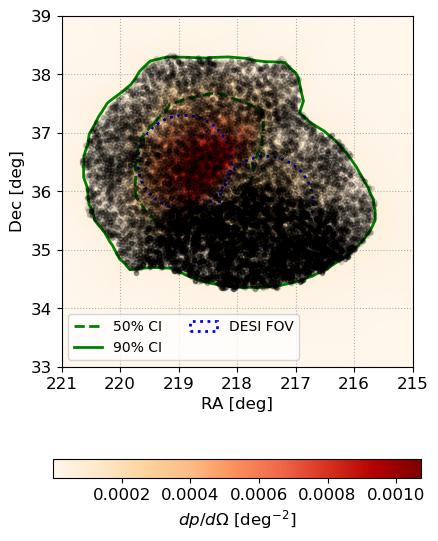

In [33]:
fig=plot_cartmap(gwfile,tile_ra=[218.9,217.5],tile_dec=[36.5,35.8],targ_ra=ra_gal,targ_dec=dec_gal,angsize=3)
fig.savefig('GW190412_targets.png', dpi=120)